### Wstęp do Uczenia Maszynowego 
##### Laboratorium 10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector, VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

**Dlaczego chcemy wybierać zmienne:**

*Uproszczenie modeli:* Ułatwienie interpretacji dla badaczy i użytkowników.

*Krótszy czas trenowania:* Mniejsza ilość danych wejściowych przyspiesza algorytmy.

*Lepsza generalizacja:* Zmniejszenie ryzyka przeuczenia (overfitting) poprzez redukcję wariancji.

*Unikanie "przekleństwa wymiarowości" (Curse of Dimensionality).*

*Poprawa dokładności (w wielu przypadkach).*

In [27]:
# wczytanie danych
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [28]:
# pozbiór danych ze względu na długi czas obliczeń
X, _, y, _  = train_test_split(X, y, train_size=5000)

In [29]:
# podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1012, test_size=0.2)

### 0. Selekcja zmiennych - stałe zmiennych

In [30]:
# poziom wariancji równy 0 = zmienna ma tylko jedną wartość
sel = VarianceThreshold(threshold=0) # metoda z modułu feature_selection
sel.fit(X_train) 

VarianceThreshold(threshold=0)

In [31]:
# sprawdzamy, które kolumny zostałe wskazane 
np.where(sel.get_support() == False)

(array([ 21,  22,  36,  37,  43,  44,  56,  57,  58,  59,  71,  72,  80,
         84,  85, 102, 103, 109, 110, 120, 131, 132, 133, 134, 145, 146,
        155, 161, 162, 170, 174, 179, 180, 186, 189, 192, 194, 195, 202,
        203, 205, 206, 214, 215, 217, 218, 220, 221, 222, 223, 226, 229,
        234, 236, 238, 239, 242, 243, 244, 246, 247, 248, 249, 250, 261,
        262, 265, 268, 285, 303, 305, 307, 308, 313, 314, 315, 317, 318,
        319, 320, 321, 327, 348, 349, 350, 351, 353, 357], dtype=int64),)

In [32]:
# sprawdzamy ile będzie kolumn pozwalając na bardzo małą wariancję, ale różną od zera
sel = VarianceThreshold(threshold=0.01)
sel.fit(X_train) 

VarianceThreshold(threshold=0.01)

In [33]:
# zdecydowanie więcej zmiennych
np.where(sel.get_support() == False)

(array([ 20,  21,  22,  25,  26,  34,  35,  36,  37,  40,  41,  42,  43,
         44,  45,  46,  47,  56,  57,  58,  59,  60,  61,  62,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  78,  80,  81,  82,  83,  84,
         85,  91,  92, 102, 103, 108, 109, 110, 120, 131, 132, 133, 134,
        135, 136, 141, 142, 143, 144, 145, 146, 155, 161, 162, 170, 174,
        179, 180, 186, 189, 192, 194, 195, 198, 202, 203, 205, 206, 210,
        214, 215, 217, 218, 220, 221, 222, 223, 226, 229, 234, 236, 238,
        239, 242, 243, 244, 246, 247, 248, 249, 250, 252, 253, 261, 262,
        265, 266, 267, 268, 269, 285, 286, 287, 288, 290, 303, 304, 305,
        306, 307, 308, 309, 313, 314, 315, 316, 317, 318, 319, 320, 321,
        327, 348, 349, 350, 351, 353, 357], dtype=int64),)

In [34]:
# przykładowa zmienna
X_train.iloc[:,45].value_counts()/X_train.shape[0]

ind_var19
0.0    0.9965
1.0    0.0035
Name: count, dtype: float64

<Axes: xlabel='ind_var19', ylabel='Count'>

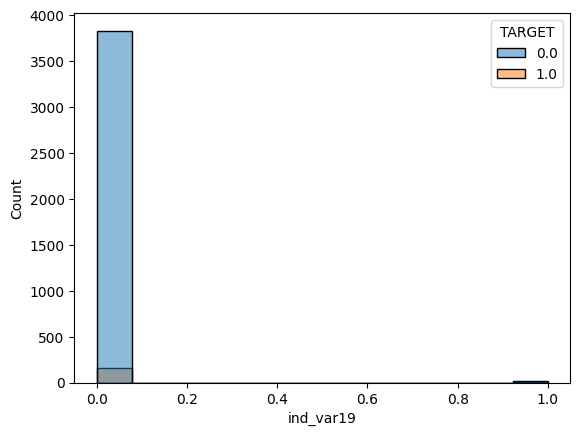

In [35]:
# analiza czy ta zmienna wpływa na wartości y
sns.histplot(pd.concat([X_train, y_train], axis=1), x = "ind_var19", hue = "TARGET")

In [36]:
# dokładniejsza analiza powyższego histogramu - zmienna nie ma wpływu na y - możemy ją pominąć
pd.concat([X_train, y_train], axis=1).groupby(['TARGET'])['ind_var19'].value_counts().unstack()

ind_var19,0.0,1.0
TARGET,,
0.0,3832,13
1.0,154,1


### 1. Selekcja zmiennych 

[Metoda `SelectFromModel()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)

Wykorzystuje informacje z innego modelu, który posiada metodę ważności zmiennych `feature_importances_` lub współczynniki `coef_`.


[Metoda `SequentialFeatureSelector()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html)

Metoda dodaje (forward selection) lub usuwa (backward selection) zmienne i tworzy podzbiór w zachłanny sposób. W każdym kroku wybiera najlepszą zmienną, którą dodaje lub usuwa bazując na wartości miary na kroswalidacji.

### Zadanie 1
----
Wczytaj zbiór danych `X.csv` i `y.csv`, podziel na zbiór treningowy i testowy w stosunku 4:1. 

a) Przygotuj `pipeline`, który przygotuje dane, uwzględnij w nim odrzucenie zmiennych stałych, dodaj model regresji logistycznej bez regularyzacji.

b) Dodaj selekcję zmiennych z wykorzystaniem `SelectFromModel()` w utworzonym `pipeline` w punkcie a). Do funkcji `SelectFromModel()` wykorzystaj model regresji logistycznej a do modelowania wykorzystaj drzewo decyzyjne. Przeprowadź optymalizację hiperparametrów drzewa.

c) Przygotuj kolejny `pipeline`, który do wyboru zmiennych zamiast funkcji `SelectFromModel()` wykorzysta funkcję `SequentialFeatureSelector()`.

#### a)

In [37]:
# podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [38]:
# wejściowa wielkość zbioru - 369 kolumn
X_train.shape

(4000, 369)

In [39]:
# pipeline dla danych ilościowych
numerical_transformer = Pipeline([
    ('scaler', StandardScaler()), # skalowanie zmiennych
    ('const', VarianceThreshold(threshold=0.01)) # odrzucenie zmiennych o prawie zerowej wariancji (posiadających jedną wartość lub bardzo mały udział innych)
])

In [40]:
numerical_transformer.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('const', VarianceThreshold(threshold=0.01))])

In [41]:
# krok preprocessingu z pipeline
X_train_after_VarianceThreshold = numerical_transformer.transform(X_train)

In [42]:
# tabela z danymi po preprocessingu z nazwami
X_train_after_VarianceThreshold = pd.DataFrame(X_train_after_VarianceThreshold, columns=numerical_transformer.get_feature_names_out())

In [ ]:
# wielkość zbioru po usunięciu stałych kolumn - około 70 - 90 kolumn mniej
X_train_after_VarianceThreshold.shape

(4000, 280)

In [44]:
# pipeline łączący przygotowanie danych i model regresji logistycznej
pipeline1 = Pipeline([
    ('pre', numerical_transformer),
    ('lm', LogisticRegression(penalty=None, max_iter=1000)) # regresja logistyczna bez regularyzacji
])

In [45]:
# budowa modelu
pipeline1.fit(X_train, y_train.TARGET)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('const',
                                  VarianceThreshold(threshold=0.01))])),
                ('lm', LogisticRegression(max_iter=1000, penalty=None))])

In [46]:
# metryki
print("Dokładność: ", round(pipeline1.score(X_test, y_test), 4)) # dokładność
print("AUC: ", round(roc_auc_score(y_test, pipeline1.predict_proba(X_test)[:,1]), 4)) # AUC

Dokładność:  0.941
AUC:  0.7081


#### b)

In [51]:
# pipeline łączący przetworzenie danych, selekcje zmiennych i model drzewa
preprocessor_all = Pipeline([
    ('pre', numerical_transformer), # przygotowanie z poprzedniej części zadania
    ('const', VarianceThreshold(threshold=0.01)), 
    ('selector', SelectFromModel(LogisticRegression(max_iter=5000, penalty="l1", solver="saga")))]) # wybór zmiennych na bazie współczynników z regresji logistycznej

pipeline2 = Pipeline([
    ('pre', preprocessor_all),
    ('tree', DecisionTreeClassifier(max_depth=6)) # model drzewa z parametrem max_depth = 6
])

In [ ]:
# krok preprocessingu z pipeline
preprocessor_all.fit(X_train, y_train.TARGET)
X_train_after_VarianceThreshold_SelectFromModel = preprocessor_all.transform(X_train)
X_train_after_VarianceThreshold_SelectFromModel = pd.DataFrame(X_train_after_VarianceThreshold_SelectFromModel, columns=preprocessor_all.get_feature_names_out())

# wielkość zbioru po selekcji zmiennych - około 220 kolumn mniej
X_train_after_VarianceThreshold_SelectFromModel.shape

In [ ]:
# budowa modelu
pipeline2.fit(X_train, y_train.TARGET)

In [54]:
# metryki
print("Dokładność: ", round(pipeline2.score(X_test, y_test), 4)) # dokładność
print("AUC: ", round(roc_auc_score(y_test, pipeline2.predict_proba(X_test)[:,1]), 4)) # AUC

Dokładność:  0.947
AUC:  0.585


#### c)

In [ ]:
# pipeline z SequentialFeatureSelector

preprocessor_all = Pipeline([
    ('pre', numerical_transformer),
    ('const', VarianceThreshold(threshold=0.01)),
    ('selectormodel', SequentialFeatureSelector(DecisionTreeClassifier()))])

pipeline = Pipeline([
    ('pre', preprocessor_all),
    ('tree', DecisionTreeClassifier())
])

In [ ]:
# siatka hiperparametrów dla modelu drzewa
params = {
    'pre__selectormodel__n_features_to_select' : [10, 20, 50], 
    'tree__max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
    'tree__min_samples_leaf': [3, 4, 5, 6, 7, 8, 9]
}

# kroswalidacja
grid_pipeline = GridSearchCV(pipeline,
                             cv = 3,
                             param_grid = params)

In [ ]:
# budowa modelu
grid_pipeline.fit(X_train, y_train.TARGET)

In [ ]:
# miara dokładności
grid_pipeline.best_score_

In [ ]:
# najlepsze hiperparametry
grid_pipeline.best_params_

In [ ]:
# metryki
print("Dokładność: ", round(grid_pipeline.score(X_test, y_test), 4)) # dokładność
print("AUC: ", round(roc_auc_score(y_test, grid_pipeline.predict_proba(X_test)[:,1]), 4)) # AUC

### 2. PCA

**Analiza Głównych Składowych (PCA)**

*Redukcja Wymiarowości:* Umożliwia zmniejszenie liczby cech (zmiennych) w zbiorze danych przy jednoczesnej maksymalizacji zachowania zmienności (informacji) w danych.

*Liniowa Transformacja:* Jest to technika liniowa. Tworzy nowe zmienne, które są kombinacjami liniowymi (ważonymi sumami) oryginalnych zmiennych.

*Wydobywanie cech (Feature Extraction):* W przeciwieństwie do wyboru cech (Feature Selection), PCA tworzy zupełnie nowe cechy (PC), zamiast po prostu wybierać podzbiór istniejących.

In [55]:
# ładowanie zbioru danych
wine_data = datasets.load_wine(as_frame=True)
df = wine_data.data

In [56]:
# skalowanie zmiennych na potrzeby PCA
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(df)

In [ ]:
# wykonanie metody PCA z n_components = 3
pca = PCA(n_components=3)
pca.fit_transform(scaled_df)

In [58]:
# eksperyment pokazuący jaki jest procent wyjaśnianej wariancji w zależności od liczby zmiennych
nums = np.arange(14)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(scaled_df)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

<Axes: >

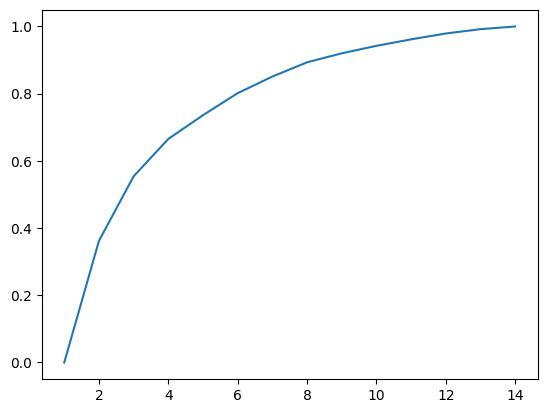

In [59]:
# wykres 
np.arange(1, 12, 1, dtype=int)
sns.lineplot(x = np.arange(1, 15, 1, dtype=int), y = var_ratio)

### Zadanie 2
----
Wczytaj zbiór danych `pima.csv`.

a) Podziel zbiór na treningowy i testowy w proporcji 4:1.

b) Na zbiorze treningowym wyznacz komponenty uzyskane metodą PCA. Sporządź wykres, który ukazuje jaki procent wariancji jest wyjaśniany przez kolejne komponenty.

c) Dopasuj model regresji logistycznej dla danych treningowych pełnych, dla danych po PCA, dla 5 pierwszych komponentów po PCA, dla 2 pierwszych komponentów po PCA.

d) Policz dokładność na zbiorze testowym dla każego modelu z punktu c).

e) Przygotuj `pipeline` ze wszystkimi krokami dla modelu regresji logistycznej na danych po PCA i policz dokładność na zbiorze testowym.

*Wyniki powinny być takie same jak dla drugiego modelu z punktu c)*

In [60]:
# wczytanie danych
pima = pd.read_csv("pima.csv")

In [61]:
# podział na y i X
y = pima.Outcome
X = pima.drop(["Outcome"], axis = 1)

#### a)

In [62]:
# podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#### b)

In [ ]:
# skalowanie zmiennych na potrzeby PCA
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

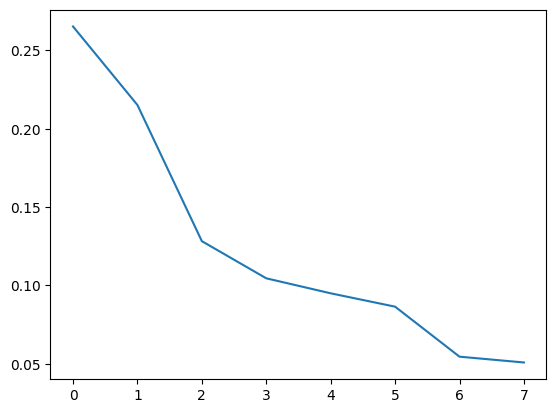

In [ ]:
# wywołanie metody PCA
pca = PCA()
# przygotwanie danych z użyciem PCA
pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_)

In [35]:
pca.components_

array([[ 0.0368636 ,  0.35491727,  0.35020141,  0.48106924,  0.45819291,
         0.45889797,  0.28736433,  0.12449829],
       [ 0.62171184,  0.20380446,  0.21023821, -0.25003011, -0.15896641,
        -0.06849743, -0.08944753,  0.6536512 ],
       [ 0.04962865, -0.52037309,  0.52134443,  0.26245864, -0.34005488,
         0.32949469, -0.39854763, -0.05495468],
       [ 0.11348992, -0.41314762,  0.03631541,  0.06709665, -0.29280616,
        -0.04586586,  0.84686761,  0.07472912],
       [ 0.40720543, -0.43739587, -0.29957686,  0.44726761,  0.46701586,
        -0.32532749, -0.153313  ,  0.07501545],
       [ 0.23821632, -0.00324771, -0.65490018,  0.04380916, -0.21693984,
         0.68032828, -0.0482712 ,  0.01376192],
       [-0.40418156,  0.18533346, -0.19593205,  0.5653752 , -0.40289811,
        -0.22667759, -0.0850896 ,  0.47254675],
       [-0.45918024, -0.40662535, -0.05486469, -0.3332479 ,  0.36867679,
         0.23234257, -0.01790795,  0.56525985]])

In [66]:
# przetworzenie danych - zbiór treningowy i testowy
X_train2 = pca.transform(X_train)
X_test2 = pca.transform(X_test)

#### c), d)

In [67]:
# regresja logistyczna
model = LogisticRegression(penalty = None, max_iter = 1000)

# pełne dane
model.fit(X_train, y_train)
print("oryginalne dane: ", np.round(model.score(X_test, y_test), 4))
# dane po PCA
model.fit(X_train2, y_train)
print("PCA dane: ", np.round(model.score(X_test2, y_test), 4))
# dane po PCA, wybór 5 pierwszych
model.fit(X_train2[:,0:5], y_train)
print("PCA dane (5 pierwszych): ", np.round(model.score(X_test2[:,0:5], y_test), 4))
# dane po PCA, wybór 2 pierwszych
model.fit(X_train2[:,0:2], y_train)
print("PCA dane (2 pierwsze): ", np.round(model.score(X_test2[:,0:2], y_test), 4))

oryginalne dane:  0.7468
PCA dane:  0.7468
PCA dane (5 pierwszych):  0.7468
PCA dane (2 pierwsze):  0.7208


#### e)

In [68]:
# w postaci pipelinu
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('regression', LogisticRegression(penalty = None, max_iter = 1000))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('regression',
                 LogisticRegression(max_iter=1000, penalty=None))])

In [69]:
round(pipeline.score(X_test, y_test), 4)

0.7468